## Problem statement

As a **technical analyst**, I am interested in obtaining the relevant charts that can help me determine when to enter/exit the market for any security. What are the relevant charts/statistics that can assist me and why?

## I. Necessary imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pandas_datareader.data as reader
import datetime as dt
from datetime import timedelta
from typing import Iterable, Union
import itertools
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from plotly import express as px

## II. Loading the relevant dataset from Yahoo Finance

Here, we need to provide the start+end dates along with the asset that we intend on analysing. It is usually beneficial to download data for one year for the analysis. Some assets may not have been in existence for one year, in which case the scope of our analysis will be limited.

In [2]:
end_date = dt.datetime.today().date()
start_date = end_date - timedelta(days=865)

In [3]:
# Index used for comparison
index = "S&P 500"
index_ticker = ("^GSPC")

In [4]:
# Modify the variables below depending on your asset of choice

target_asset = "Apple"
target_ticker = ("AAPL")
is_security_new = False    # Has the IPO been within the last 18 months?

In [5]:
original_df = reader.get_data_yahoo(target_ticker, start_date, end_date)
original_index_df = reader.get_data_yahoo(index_ticker, start_date, end_date)

In [6]:
original_df.head()

High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2019-11-18  66.857498  66.057503  66.449997  66.775002   86703200.0  65.713913
2019-11-19  67.000000  66.347504  66.974998  66.572502   76167200.0  65.514641
2019-11-20  66.519997  65.099998  66.385002  65.797501  106234400.0  64.751953
2019-11-21  66.002502  65.294998  65.922501  65.502502  121395200.0  64.461639
2019-11-22  65.794998  65.209999  65.647499  65.445000   65325200.0  64.405037

## III. Preprocessing input data

In [7]:
def preprocess_dfs(list_of_dfs: Iterable, is_security_new: bool) -> Iterable:
    processed_dfs = []
    for df in list_of_dfs:
        df = df.rename(columns={"Adj Close": "closing_price"})
        
        df["20_d_MA_price"] = df["closing_price"].rolling(20).mean()
        df["60_d_MA_price"] = df["closing_price"].rolling(60).mean()
        
        df["20_d_rolling_std_price"] = df["closing_price"].rolling(20).std()
        df["upper_bollinger_band"] = df["20_d_MA_price"] + 2*df["20_d_rolling_std_price"]
        df["lower_bollinger_band"] = df["20_d_MA_price"] - 2*df["20_d_rolling_std_price"]
        df["bollinger_band_width"] = df["upper_bollinger_band"] - df["lower_bollinger_band"]

        if not is_security_new:
            df["50_d_MA_price"] = df["closing_price"].rolling(50).mean()
            df["200_d_MA_price"] = df["closing_price"].rolling(200).mean()
        
        processed_dfs += [df.reset_index()]
    
    return processed_dfs

In [8]:
def calculate_daily_returns(list_of_dfs: Iterable) -> Iterable:
    enriched_dfs = []
    
    for df in list_of_dfs:
        df["daily_return"] = np.log(df["closing_price"]/df["closing_price"].shift())
        df = df.dropna(subset=["daily_return"])
        
        enriched_dfs += [df]
    
    return enriched_dfs

In [9]:
def calculate_oscillator_metrics(list_of_dfs: Iterable) -> Iterable:
    enriched_dfs = []
    
    for df in list_of_dfs:        
        # RSI
        mask = df["daily_return"] >= 0
        df["is_up"] = (df["daily_return"] >= 0).replace({True: 1, False: 0})
        df["is_down"] = (df["daily_return"] < 0).replace({True: 1, False: 0})
        df["up_return"] = df["is_up"]*df["daily_return"]
        df["down_return"] = df["is_down"]*abs(df["daily_return"])
        df = df.drop(columns=["is_up", "is_down"])
        
        df["RSI"] = 100 - 100/(1+df["up_return"].rolling(14).sum()/df["down_return"].rolling(14).sum())
        
        # Stochastic oscillator
        df["14_d_rolling_min"] = df["closing_price"].rolling(14).min()
        df["14_d_rolling_max"] = df["closing_price"].rolling(14).max()
        df["percent_K"] = (df["closing_price"] - df["14_d_rolling_min"])/(df["14_d_rolling_max"] - df["14_d_rolling_min"])
        df["percent_D"] = df["percent_K"].rolling(3).mean()

        enriched_dfs += [df]
    
    return enriched_dfs

In [10]:
def get_last_year_data(list_of_dfs: Iterable) -> Iterable:
    filtered_dfs = []
    
    for df in list_of_dfs:
        df = df.loc[df["Date"] >= pd.Timestamp(end_date - timedelta(days=365))]
        filtered_dfs += [df]
    
    return filtered_dfs

In [11]:
processed_dfs = preprocess_dfs(list_of_dfs=[original_df, original_index_df], is_security_new=is_security_new)

In [12]:
processed_dfs = calculate_daily_returns(processed_dfs)

In [13]:
processed_dfs = calculate_oscillator_metrics(processed_dfs)

In [14]:
processed_dfs = get_last_year_data(processed_dfs)

In [15]:
df, index_df = processed_dfs

In [16]:
df.head()

Date        High         Low        Open       Close       Volume  \
343 2021-03-31  123.519997  121.150002  121.650002  122.150002  118323800.0   
344 2021-04-01  124.180000  122.489998  123.660004  123.000000   75089100.0   
345 2021-04-05  126.160004  123.070000  123.870003  125.900002   88651200.0   
346 2021-04-06  127.129997  125.650002  126.500000  126.209999   80171300.0   
347 2021-04-07  127.919998  125.139999  125.830002  127.900002   83466700.0   

     closing_price  20_d_MA_price  60_d_MA_price  20_d_rolling_std_price  ...  \
343     121.428284     120.686200     127.509565                2.016625  ...   
344     122.273270     120.828852     127.380092                2.023257  ...   
345     125.156136     121.051529     127.371625                2.241893  ...   
346     125.464302     121.541119     127.296825                2.067801  ...   
347     127.144318     121.879607     127.231332                2.394991  ...   

     50_d_MA_price  200_d_MA_price  daily_return  up_return  down_return  \
343     127.340046      116.517289      0.018592   0.018592          0.0   
344     127.164430      116.693346      0.006935   0.006935          0.0   
345     126.950386      116.884423      0.023304   0.023304          0.0   
346     126.698831      117.076867      0.002459   0.002459          0.0   
347     126.404446      117.280197      0.013302   0.013302          0.0   

           RSI  14_d_rolling_min  14_d_rolling_max  percent_K  percent_D  
343  50.416879        119.191582        124.828087   0.396824   0.216353  
344  54.340911        119.191582        124.828087   0.546737   0.314521  
345  54.129048        119.191582        125.156136   1.000000   0.647854  
346  51.453241        119.191582        125.464302   1.000000   0.848912  
347  56.838478        119.191582        127.144318   1.000000   1.000000  

[5 rows x 23 columns]

## IV. Using PlotLy for Technical Analysis

In [17]:
plotly_x_axis_config = dict(
    rangeselector=dict(
        buttons=list([
            dict(count=1,
                     label="1M",
                     step="month",
                     stepmode="backward"),
            dict(count=6,
                 label="6M",
                 step="month",
                 stepmode="backward"),
            dict(count=1,
                 label="YTD",
                 step="year",
                 stepmode="todate"),
            dict(count=1,
                 label="1Y",
                 step="year",
                 stepmode="backward"),
            dict(step="all")
        ])
    ),
    rangeslider=dict(
        visible=True
    ),
    type="date"
)

**Line plot**

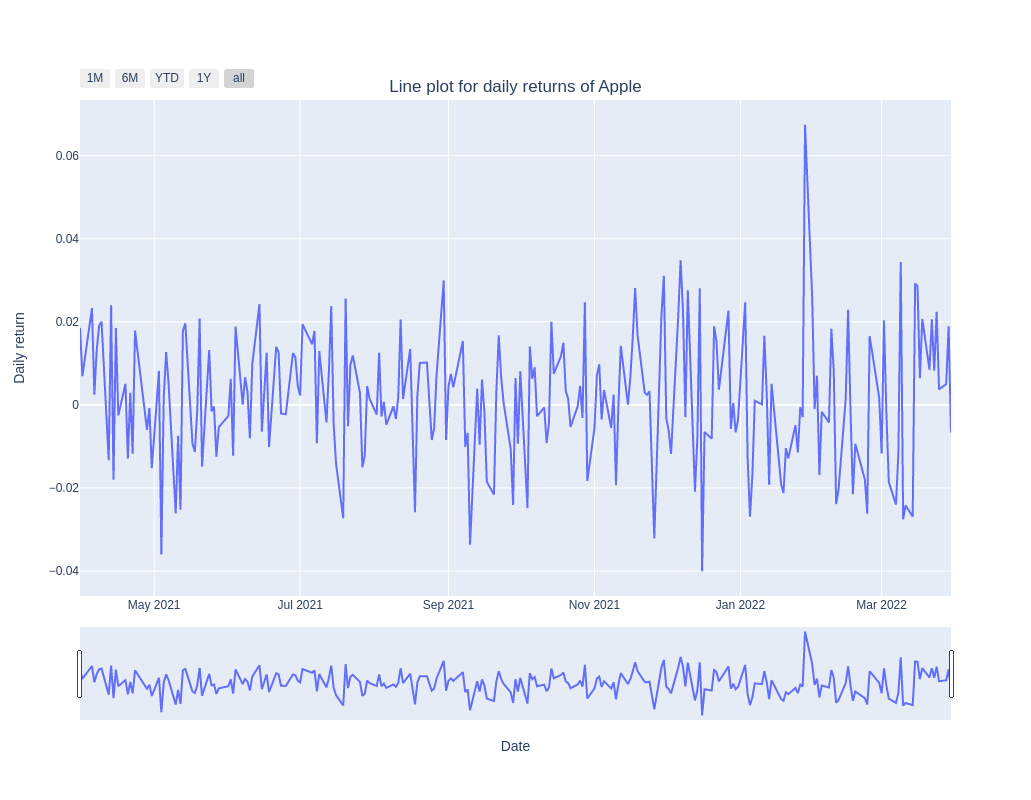

In [18]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df["Date"], y=df["daily_return"]))

fig.update_layout(
    title_text=f"Line plot for daily returns of {target_asset}",
    title_x=0.5,
    title_y=0.9,
    xaxis=plotly_x_axis_config,
    height=800
)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Daily return")

**Relative strength (w.r.t S&P 500)**

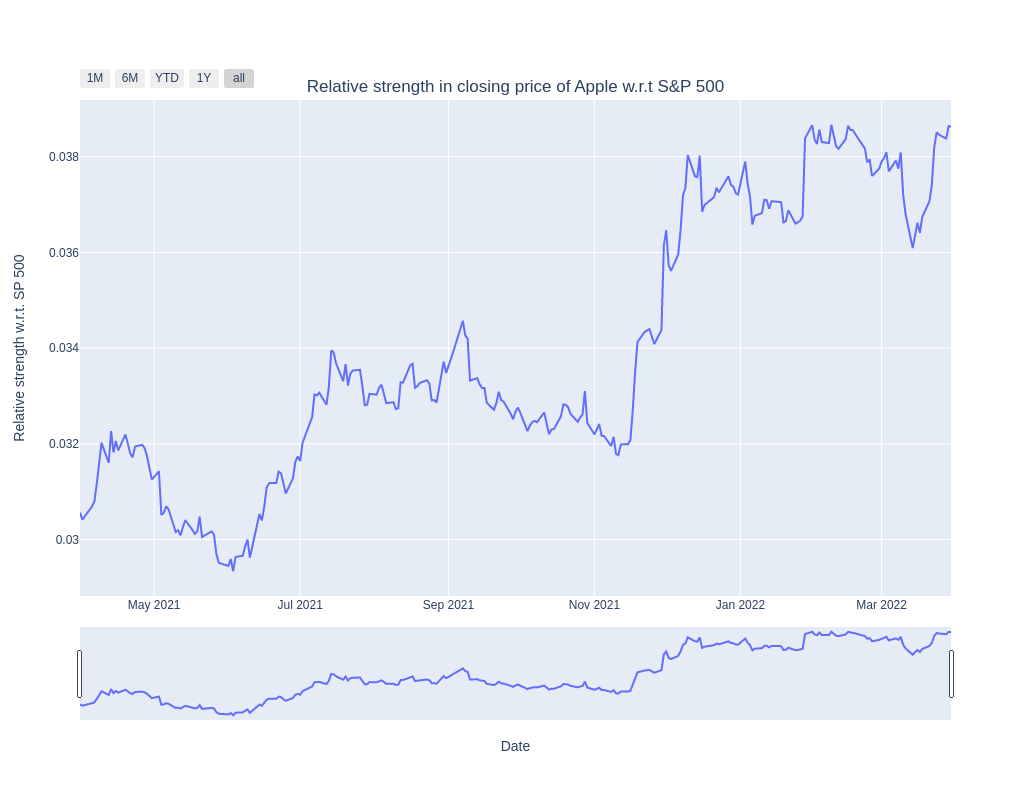

In [19]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df["Date"], y=df["closing_price"]/index_df["closing_price"]))

fig.update_layout(
    title_text=f"Relative strength in closing price of {target_asset} w.r.t {index}",
    title_x=0.5,
    title_y=0.9,
    xaxis=plotly_x_axis_config,
    height=800
)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Relative strength w.r.t. SP 500")

**Candlestick plot**

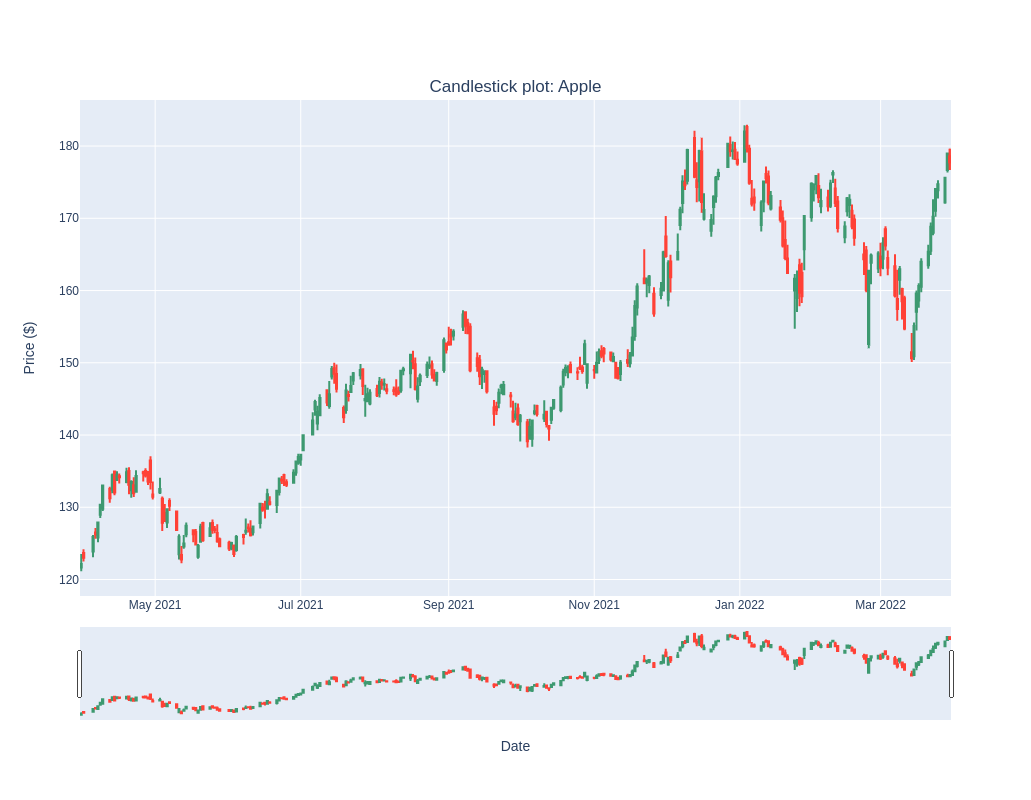

In [20]:
fig = go.Figure(data=[go.Candlestick(x=df["Date"],
                open=df["Open"],
                high=df["High"],
                low=df["Low"],
                close=df["Close"])],
               )

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Price ($)")
fig.update_layout(title_text=f"Candlestick plot: {target_asset}", 
                  title_x=0.5,
                  title_y=0.9,
                  height=800
                 )
fig.show()

**Price and Volume trends**

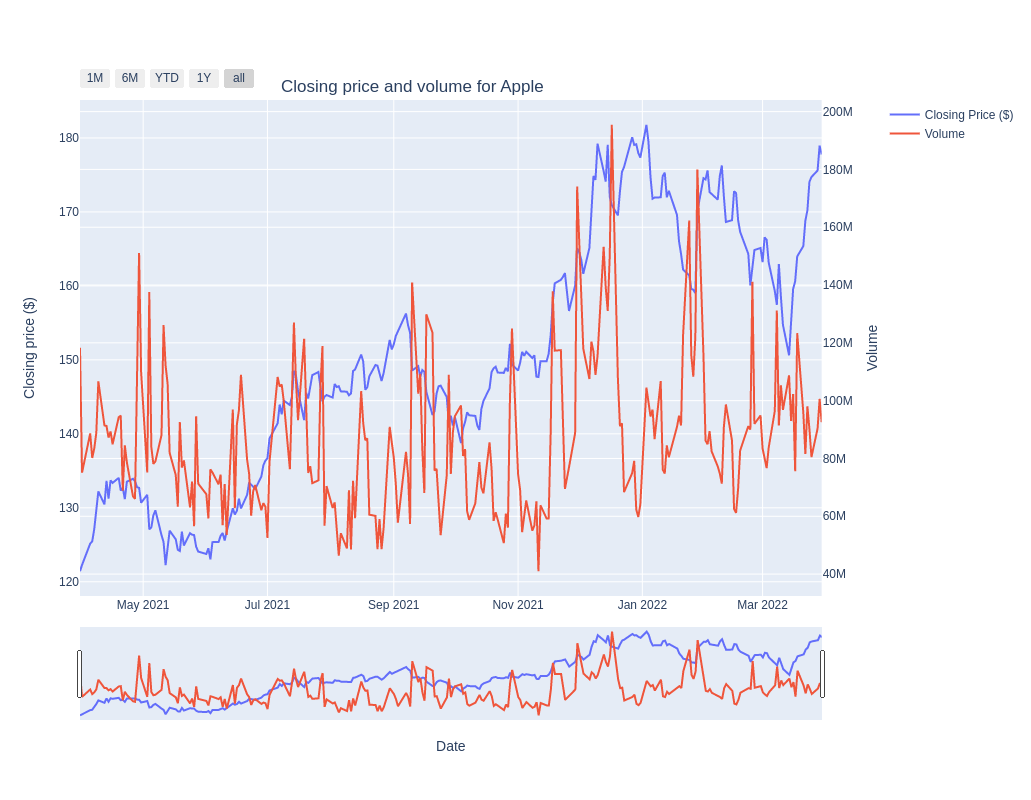

In [21]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df["Date"], y=df["closing_price"], name="Closing Price ($)"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df["Date"], y=df["Volume"], name="Volume"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text=f"Closing price and volume for {target_asset}",
    title_x=0.4,
    title_y=0.9,
    xaxis=plotly_x_axis_config,
    height=800
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Closing price ($)", secondary_y=False)
fig.update_yaxes(title_text="Volume", secondary_y=True)

fig.show()

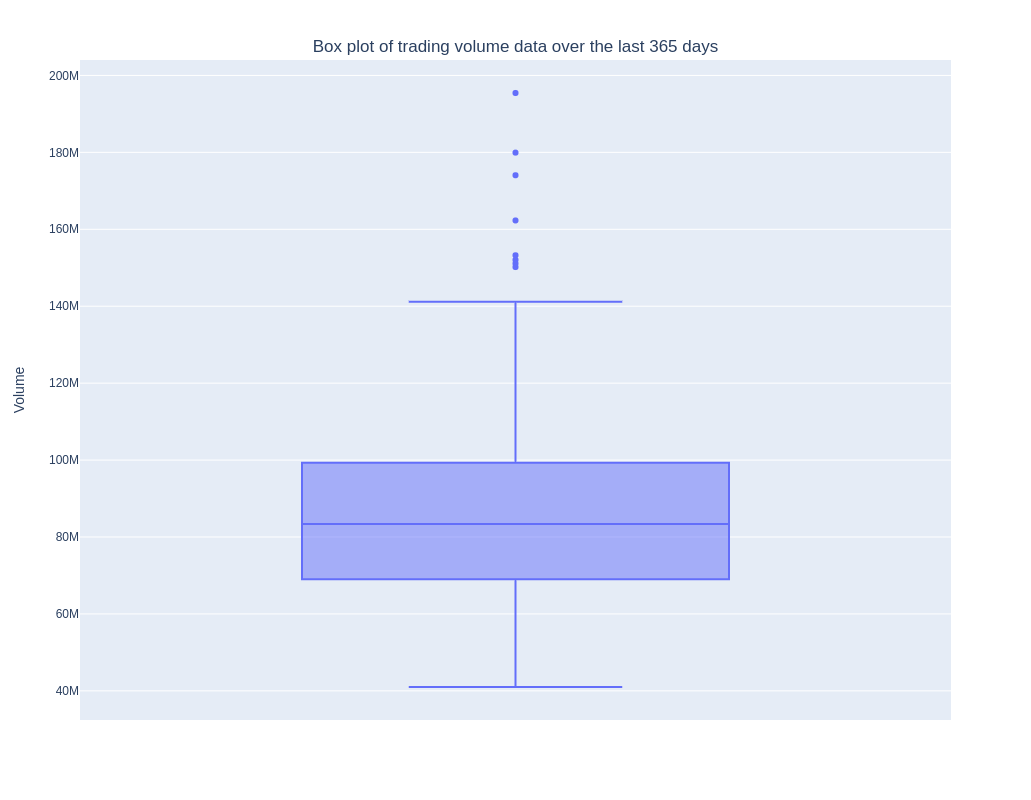

In [22]:
fig = px.box(df, y="Volume")
fig.update_layout(
    title_text=f"Box plot of trading volume data over the last 365 days",
    title_x=0.5,
    title_y=0.95,
    height=800
)
fig.show()

**Inspecting a bar chart for continuation patterns**

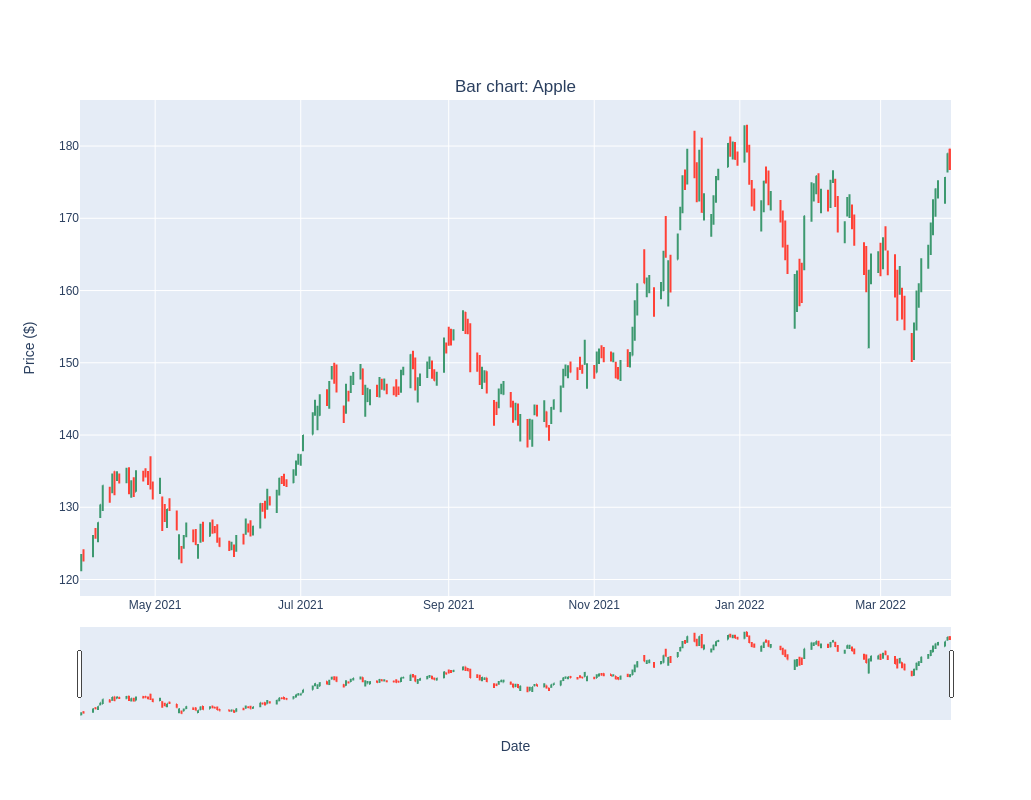

In [23]:
fig = go.Figure(data=[go.Ohlc(x=df["Date"],
                open=df["Open"],
                high=df["High"],
                low=df["Low"],
                close=df["Close"])],
               )

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Price ($)")
fig.update_layout(title_text=f"Bar chart: {target_asset}", 
                  title_x=0.5,
                  title_y=0.9,
                  height=800
                 )
fig.show()

**Moving average as a price-based indicator**

In [24]:
df.head()

Date        High         Low        Open       Close       Volume  \
343 2021-03-31  123.519997  121.150002  121.650002  122.150002  118323800.0   
344 2021-04-01  124.180000  122.489998  123.660004  123.000000   75089100.0   
345 2021-04-05  126.160004  123.070000  123.870003  125.900002   88651200.0   
346 2021-04-06  127.129997  125.650002  126.500000  126.209999   80171300.0   
347 2021-04-07  127.919998  125.139999  125.830002  127.900002   83466700.0   

     closing_price  20_d_MA_price  60_d_MA_price  20_d_rolling_std_price  ...  \
343     121.428284     120.686200     127.509565                2.016625  ...   
344     122.273270     120.828852     127.380092                2.023257  ...   
345     125.156136     121.051529     127.371625                2.241893  ...   
346     125.464302     121.541119     127.296825                2.067801  ...   
347     127.144318     121.879607     127.231332                2.394991  ...   

     50_d_MA_price  200_d_MA_price  daily_return  up_return  down_return  \
343     127.340046      116.517289      0.018592   0.018592          0.0   
344     127.164430      116.693346      0.006935   0.006935          0.0   
345     126.950386      116.884423      0.023304   0.023304          0.0   
346     126.698831      117.076867      0.002459   0.002459          0.0   
347     126.404446      117.280197      0.013302   0.013302          0.0   

           RSI  14_d_rolling_min  14_d_rolling_max  percent_K  percent_D  
343  50.416879        119.191582        124.828087   0.396824   0.216353  
344  54.340911        119.191582        124.828087   0.546737   0.314521  
345  54.129048        119.191582        125.156136   1.000000   0.647854  
346  51.453241        119.191582        125.464302   1.000000   0.848912  
347  56.838478        119.191582        127.144318   1.000000   1.000000  

[5 rows x 23 columns]

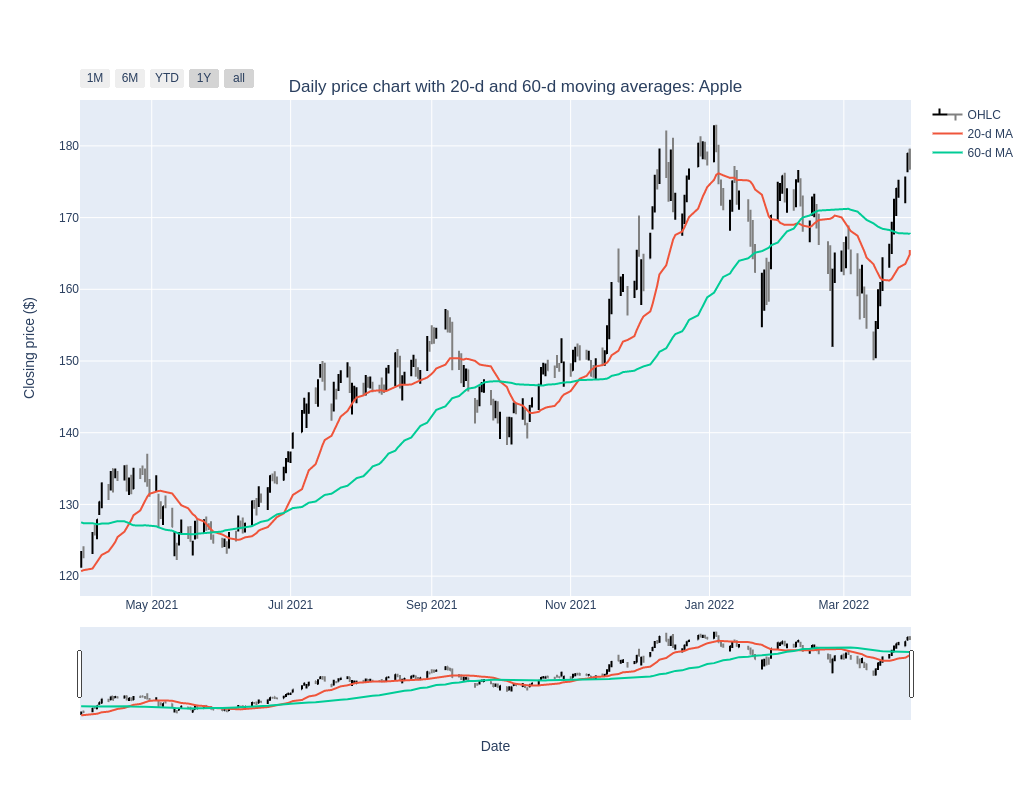

In [25]:
# Make plotly subplots
fig = make_subplots()

# Add traces
fig = go.Figure(data=[go.Ohlc(x=df["Date"],
                open=df["Open"],
                high=df["High"],
                low=df["Low"],
                close=df["Close"],
                increasing_line_color= "black", 
                decreasing_line_color= "gray",
                name="OHLC")],
               )

fig.add_trace(
    go.Scatter(x=df["Date"], y=df["20_d_MA_price"], name="20-d MA"),
)

fig.add_trace(
    go.Scatter(x=df["Date"], y=df["60_d_MA_price"], name="60-d MA"),
)

# Add figure title
fig.update_layout(
    title_text=f"Daily price chart with 20-d and 60-d moving averages: {target_asset}",
    title_x=0.28,
    title_y=0.9,
    xaxis=plotly_x_axis_config,
    height=800
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Closing price ($)")

fig.show()

**Identifying the gold and/or dead crosses**

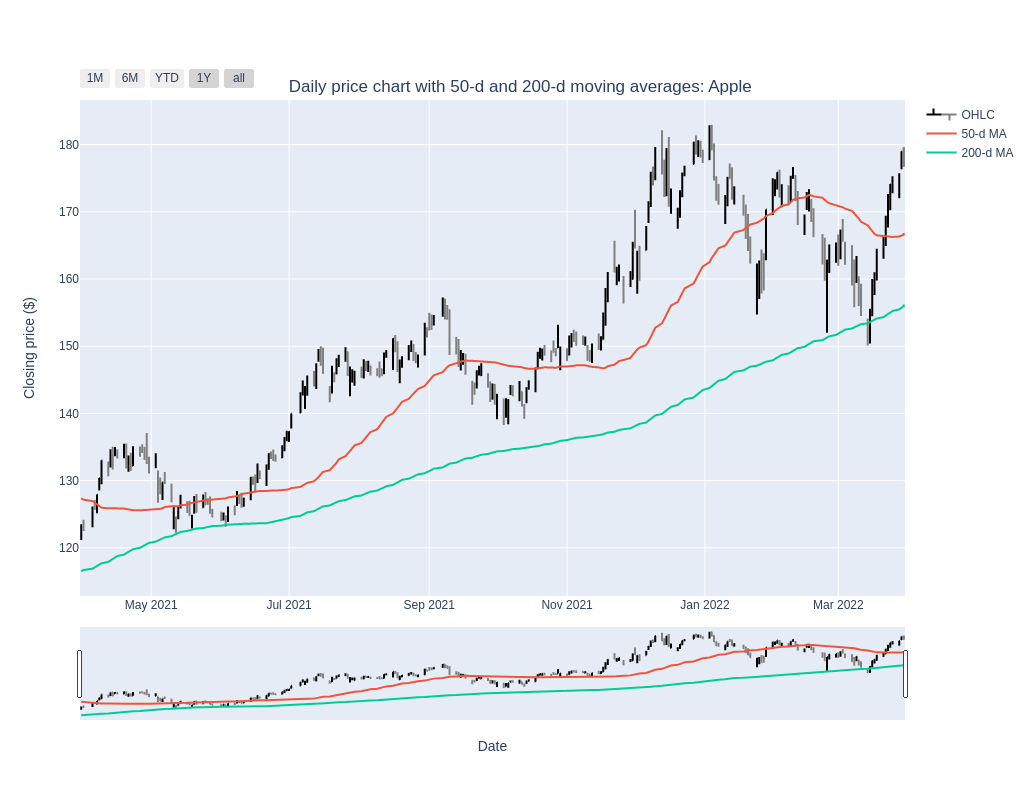

In [26]:
if is_security_new:
    print("Unable to create 50-d v 200-d MA plots, because we have insufficient data.")
else:
    # Make plotly subplots
    fig = make_subplots()

    # Add traces
    fig = go.Figure(data=[go.Ohlc(x=df["Date"],
                    open=df["Open"],
                    high=df["High"],
                    low=df["Low"],
                    close=df["Close"],
                    increasing_line_color= "black", 
                    decreasing_line_color= "gray",
                    name="OHLC")],
                   )

    fig.add_trace(
        go.Scatter(x=df["Date"], y=df["50_d_MA_price"], name="50-d MA"),
    )

    fig.add_trace(
        go.Scatter(x=df["Date"], y=df["200_d_MA_price"], name="200-d MA"),
    )

    # Add figure title
    fig.update_layout(
        title_text=f"Daily price chart with 50-d and 200-d moving averages: {target_asset}",
        title_x=0.28,
        title_y=0.9,
        height=800,
        xaxis=plotly_x_axis_config
    )

    # Set x-axis title
    fig.update_xaxes(title_text="Date")

    # Set y-axes titles
    fig.update_yaxes(title_text="Closing price ($)")

    fig.show()

**Bollinger bands**

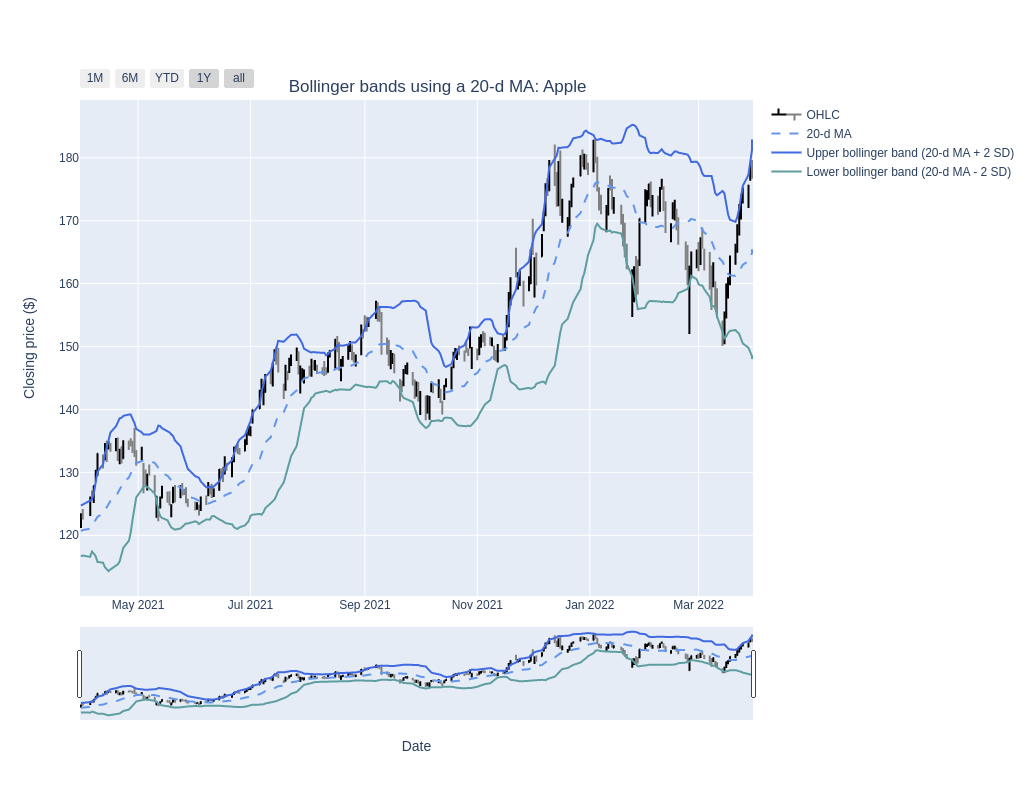

In [27]:
# Make plotly subplots
fig = make_subplots()

# Add traces
fig = go.Figure(data=[go.Ohlc(x=df["Date"],
                open=df["Open"],
                high=df["High"],
                low=df["Low"],
                close=df["Close"],
                increasing_line_color= "black", 
                decreasing_line_color= "gray",
                name="OHLC")],
               )

fig.add_trace(
    go.Scatter(x=df["Date"], y=df["20_d_MA_price"], name="20-d MA", line = dict(color='cornflowerblue', dash='dash'))
)

fig.add_trace(
    go.Scatter(x=df["Date"], y=df["upper_bollinger_band"], name="Upper bollinger band (20-d MA + 2 SD)", 
               line = dict(color='royalblue')),
    
)

fig.add_trace(
    go.Scatter(x=df["Date"], y=df["lower_bollinger_band"], name="Lower bollinger band (20-d MA - 2 SD)",
               line = dict(color='cadetblue')),
)

# Add figure title
fig.update_layout(
    title_text=f"Bollinger bands using a 20-d MA: {target_asset}",
    title_x=0.28,
    title_y=0.9,
    height=800,
    xaxis=plotly_x_axis_config
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Closing price ($)")

fig.show()

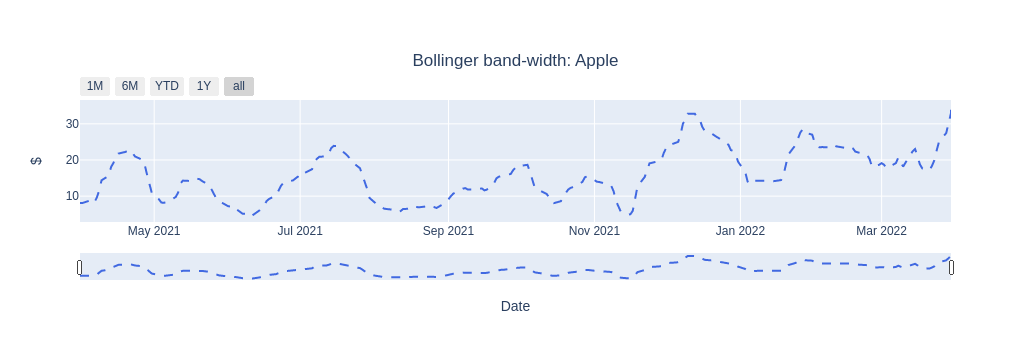

In [28]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df["Date"], y=df["bollinger_band_width"],
              line = dict(color='royalblue', dash='dash'))
)

fig.update_layout(
    title_text=f"Bollinger band-width: {target_asset}",
    title_x=0.5,
    title_y=0.85,
    xaxis=plotly_x_axis_config
)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="$")

fig.show()

**Momentum oscillators**

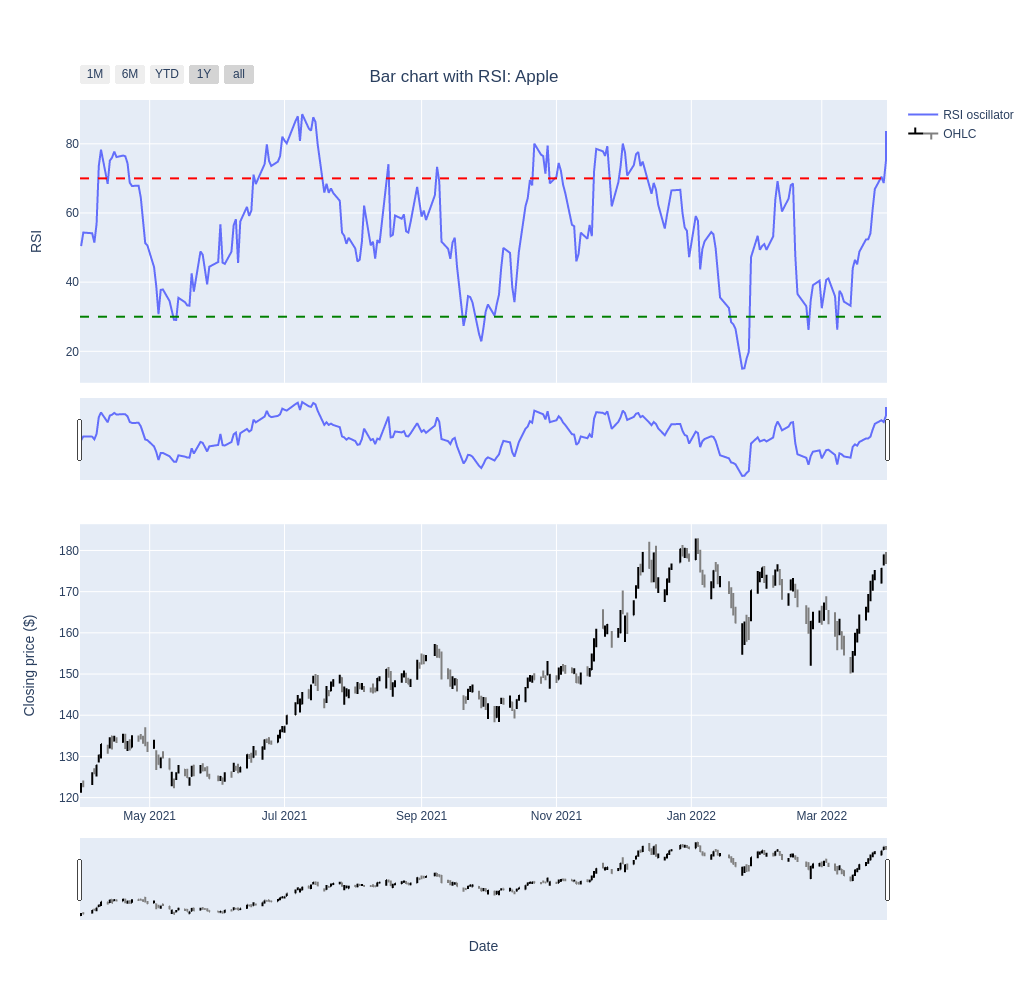

In [29]:
# Create figure with secondary y-axis
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.2)

# Add traces
fig.add_trace(
    go.Scatter(x=df["Date"], y=df["RSI"], name="RSI oscillator"),
    row=1,
    col=1
)

fig.add_hline(y=30, line = dict(color='green', dash='dash'))
fig.add_hline(y=70, line = dict(color='red', dash='dash'))

fig.add_trace(go.Ohlc(x=df["Date"],
                open=df["Open"],
                high=df["High"],
                low=df["Low"],
                close=df["Close"],
                increasing_line_color= "black", 
                decreasing_line_color= "gray",
                name="OHLC"),
              row=2,
              col=1
               )

# Add figure title
fig.update_layout(
    title_text=f"Bar chart with RSI: {target_asset}",
    title_x=0.45,
    title_y=0.93,
    xaxis=plotly_x_axis_config,
    yaxis=dict(title="RSI"),
    yaxis2=dict(title="Closing price ($)"),
    xaxis2=dict(title="Date"),
    height=1000
)

# Set x-axis title
fig.update_xaxes(rangeslider_thickness = 0.1)


fig.show()

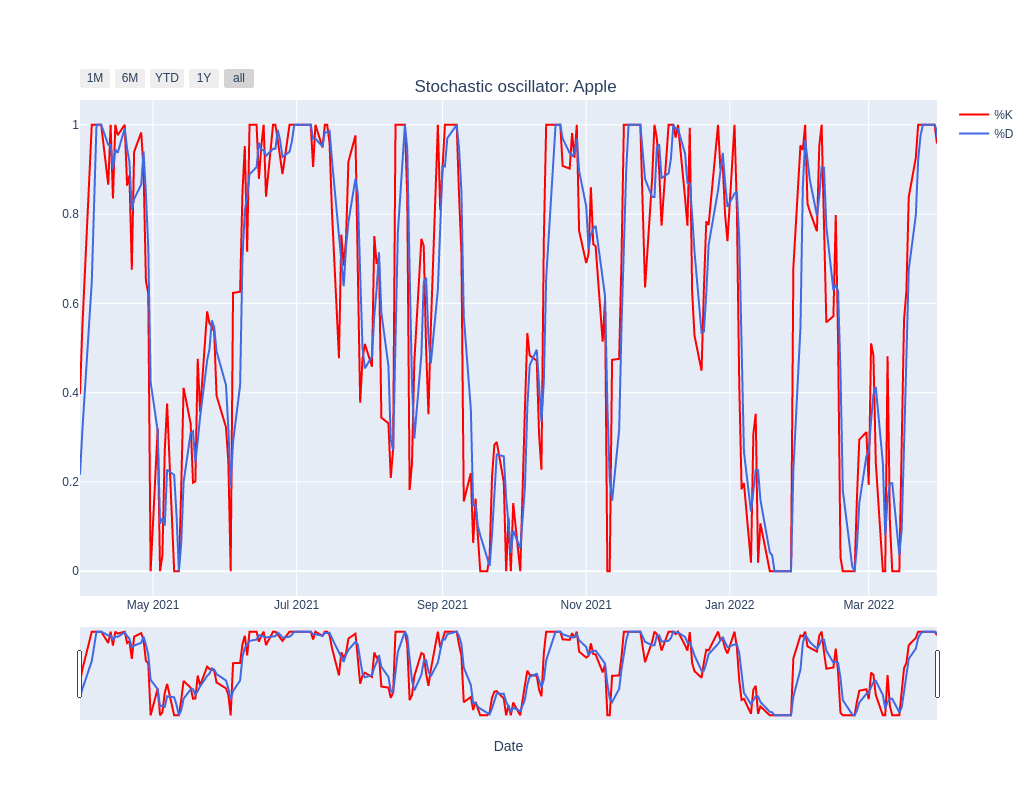

In [30]:
# Make plotly subplots
fig = make_subplots()

#Add traces

fig.add_trace(
    go.Scatter(x=df["Date"], y=df["percent_K"], name="%K", line = dict(color='red'))
)

fig.add_trace(
    go.Scatter(x=df["Date"], y=df["percent_D"], name="%D", line = dict(color='royalblue')),
    
)


# Add figure title
fig.update_layout(
    title_text=f"Stochastic oscillator: {target_asset}",
    title_x=0.5,
    title_y=0.9,
    height=800,
    xaxis=plotly_x_axis_config
)

# Set x-axis title
fig.update_xaxes(title_text="Date")


fig.show()

**Sentiment indicators**